# Setting Up the Environment

<span style="font-size:larger;">In this step, we're preparing our environment by installing and importing the necessary libraries and modules for our project. This is what each of the libraries do: </span>

- `youtube-dl`: Downloads videos from various platforms.
- `pandas`: Manipulates and analyzes tabular data efficiently.
- `youtube-transcript-api`: Fetches transcripts of YouTube videos.
- `google-api-python-client`: Interacts with Google's APIs.
- `isodate`: Parses and formats ISO 8601 dates and times.
- `scikit-learn`: Offers machine learning algorithms and tools.
- `transformers`: Facilitates natural language processing tasks.
- `wordcloud`: Visualizes word frequency in text data.
- `seaborn`: Creates statistical visualizations with customizable styles.

In [81]:
!pip install youtube-dl pandas
!pip install youtube-transcript-api
!pip install --upgrade google-api-python-client
!pip install isodate
!pip install scikit-learn
!pip install transformers
!pip install wordcloud

#for retrieving the data
import youtube_dl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
key = "YOUR_API_KEY"

# Extracting the data

<span style="font-size:larger;">YoutubeDL object that handles video downloading and information extraction tasks.
This code fetches information about videos from the 3Blue1Brown YouTube channel, including titles and URLs. It then organizes this data into a structured format for further analysis.</span>


In [82]:
# Set up youtube_dl options
ydl_opts = {
    'quiet': True,
    'extract_flat': 'in_playlist',
    'force_generic_extractor': True,
}

# The 3Blue1Brown channel URL
channel_url = 'https://www.youtube.com/c/3blue1brown/videos'

# Fetch the video information
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    info_dict = ydl.extract_info(channel_url, download=False)

# Extract video titles and URLs
video_details = [{'title': entry['title'], 'url': f"https://www.youtube.com/watch?v={entry['id']}"} for entry in info_dict['entries']]

# Convert to DataFrame
df_videos = pd.DataFrame(video_details)
print(df_videos.head())

                                               title  \
0  Attention in transformers, visually explained ...   
1  But what is a GPT?  Visual intro to transforme...   
2  4 questions about the refractive index | Optic...   
3  But why would light "slow down"? | Optics puzz...   
4   25 Math explainers you may enjoy | SoME3 results   

                                           url  
0  https://www.youtube.com/watch?v=eMlx5fFNoYc  
1  https://www.youtube.com/watch?v=wjZofJX0v4M  
2  https://www.youtube.com/watch?v=Cz4Q4QOuoo8  
3  https://www.youtube.com/watch?v=KTzGBJPuJwM  
4  https://www.youtube.com/watch?v=6a1fLEToyvU  


# More Data from "YouTubeTranscriptApi"

<span style="font-size: larger;">The `YouTubeTranscriptApi` is a Python library that simplifies the process of accessing and retrieving transcripts from YouTube videos programmatically. It provides an easy-to-use interface for fetching textual content from videos, facilitating analysis and research tasks involving YouTube content. This cell fetches transcripts from YouTube videos using the `YouTubeTranscriptApi` library. It defines a function to handle transcript retrieval and applies it to each video URL in the DataFrame. The extracted transcript data is stored in a CSV file for further analysis.</span>


In [83]:
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api._errors import TranscriptsDisabled, NoTranscriptFound

def get_transcript(video_id):
    try:
        transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)
        transcript = transcript_list.find_transcript(['en']).fetch()
        transcript_text = ' '.join([part['text'] for part in transcript])
        return transcript_text
    except (TranscriptsDisabled, NoTranscriptFound):
        return "Transcript not available"
    except Exception as e:
        return f"Error: {str(e)}"

# Assuming df_videos is a DataFrame containing the video URLs
# You need to extract video IDs from URLs
df_videos['video_id'] = df_videos['url'].apply(lambda x: x.split('watch?v=')[-1])
df_videos['transcript'] = df_videos['video_id'].apply(get_transcript)

#print(df_videos.head())

df_videos.to_csv('3blue1brown_video_transcripts.csv', index=False)
# Load the CSV file back into a DataFrame
df_loaded = pd.read_csv('3blue1brown_video_transcripts.csv')

# Display the first few rows of the DataFrame
print(df_loaded.head())

                                               title  \
0  Attention in transformers, visually explained ...   
1  But what is a GPT?  Visual intro to transforme...   
2  4 questions about the refractive index | Optic...   
3  But why would light "slow down"? | Optics puzz...   
4   25 Math explainers you may enjoy | SoME3 results   

                                           url     video_id  \
0  https://www.youtube.com/watch?v=eMlx5fFNoYc  eMlx5fFNoYc   
1  https://www.youtube.com/watch?v=wjZofJX0v4M  wjZofJX0v4M   
2  https://www.youtube.com/watch?v=Cz4Q4QOuoo8  Cz4Q4QOuoo8   
3  https://www.youtube.com/watch?v=KTzGBJPuJwM  KTzGBJPuJwM   
4  https://www.youtube.com/watch?v=6a1fLEToyvU  6a1fLEToyvU   

                                          transcript  
0  In the last chapter, you and I started to step...  
1  The initials GPT stand for Generative Pretrain...  
2  The last video I put out was about the index o...  
3  I realized recently that I didn't really under...  
4  This y

# Lets observe the missing values

In [86]:
print("Shape of DataFrame:", df_loaded.shape)
print("Missing values in each column:\n", df_loaded.isnull().sum())
print(df_loaded.describe(include='all'))

Shape of DataFrame: (127, 4)
Missing values in each column:
 title         0
url           0
video_id      0
transcript    0
dtype: int64
                                                    title  \
count                                                 127   
unique                                                127   
top     Attention in transformers, visually explained ...   
freq                                                    1   

                                                url     video_id  \
count                                           127          127   
unique                                          127          127   
top     https://www.youtube.com/watch?v=eMlx5fFNoYc  eMlx5fFNoYc   
freq                                              1            1   

                      transcript  
count                        127  
unique                       124  
top     Transcript not available  
freq                           3  


# We check the availability of the transcipts

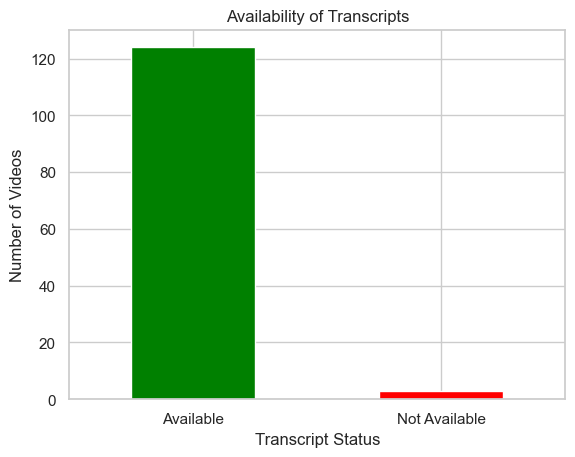

In [87]:
# Count the occurrence of unique values in the 'transcript' column
transcript_availability = df_loaded['transcript'].apply(lambda x: 'Available' if x != 'Transcript not available' else 'Not Available').value_counts()

# Plotting
transcript_availability.plot(kind='bar', color=['green', 'red'])
plt.title('Availability of Transcripts')
plt.xlabel('Transcript Status')
plt.ylabel('Number of Videos')
plt.xticks(rotation=0)
plt.show()

<span style="font-size:larger;">This code counts and visualizes the availability of transcripts for the loaded videos. Most videos have transcripts available, ensuring usable data for analysis.</span>

# Data from YoutubeAPI V3
<span style="font-size:larger;">We combine data from another transcript the Youtube API V3. This code utilizes the API to fetch statistics for the loaded videos, including view count, like count, dislike count, and comment count. Later we processed the dataframe. The code expands the retrieved statistics into separate columns in the DataFrame, removes unnecessary columns, and converts 'Not Available' values to NaN for better handling. Missing values are optionally dropped based on analysis needs. Finally, the DataFrame is saved to a CSV file for further analysis.</span>

In [88]:
from googleapiclient.discovery import build

# Initialize the YouTube API client
youtube = build('youtube', 'v3', developerKey=key)  
def fetch_video_statistics(video_id):
    try:
        response = youtube.videos().list(
            part='statistics',  # Specify the part
            id=video_id          # Specify the video ID
        ).execute()

        if response['items']:
            # Extract statistics
            stats = response['items'][0].get('statistics', {})
            return {
                'viewCount': stats.get('viewCount', 'Not Available'),
                'likeCount': stats.get('likeCount', 'Not Available'),
                'dislikeCount': stats.get('dislikeCount', 'Not Available'),
                'commentCount': stats.get('commentCount', 'Not Available')
            }
        else:
            return {'error': 'No data found'}
    except Exception as e:
        return {'error': str(e)}

    
# 'video_id' from the DataFrame to fetch statistics
df_loaded['statistics'] = df_loaded['video_id'].apply(fetch_video_statistics)


# Expand the dictionary into separate columns
df_loaded['views'] = df_loaded['statistics'].apply(lambda x: x['viewCount'] if 'viewCount' in x else 'Not Available')
df_loaded['likes'] = df_loaded['statistics'].apply(lambda x: x['likeCount'] if 'likeCount' in x else 'Not Available')
df_loaded['dislikes'] = df_loaded['statistics'].apply(lambda x: x['dislikeCount'] if 'dislikeCount' in x else 'Not Available')
df_loaded['comments'] = df_loaded['statistics'].apply(lambda x: x['commentCount'] if 'commentCount' in x else 'Not Available')


# Remove the 'statistics' & 'dislikes' column
df_loaded.drop('statistics', axis=1, inplace=True)
df_loaded.drop('dislikes', axis=1, inplace=True)


# Replace 'Not Available' with NaN and convert columns to appropriate data types
df_loaded.replace('Not Available', pd.NA, inplace=True)
df_loaded['views'] = df_loaded['views'].astype('Int64')
df_loaded['likes'] = df_loaded['likes'].astype('Int64')
df_loaded['comments'] = df_loaded['comments'].astype('Int64')


# Optionally, fill or drop missing values based on analysis needs
df_loaded.dropna(subset=['views', 'likes', 'comments'], inplace=True)

# Save the DataFrame to a CSV file
df_loaded.to_csv('3blue1brown_video_data_complete.csv', index=False)


# Reload the DataFrame to verify changes
df_loaded = pd.read_csv('3blue1brown_video_data_complete.csv')
print(df_loaded.head())

                                               title  \
0  Attention in transformers, visually explained ...   
1  But what is a GPT?  Visual intro to transforme...   
2  4 questions about the refractive index | Optic...   
3  But why would light "slow down"? | Optics puzz...   
4   25 Math explainers you may enjoy | SoME3 results   

                                           url     video_id  \
0  https://www.youtube.com/watch?v=eMlx5fFNoYc  eMlx5fFNoYc   
1  https://www.youtube.com/watch?v=wjZofJX0v4M  wjZofJX0v4M   
2  https://www.youtube.com/watch?v=Cz4Q4QOuoo8  Cz4Q4QOuoo8   
3  https://www.youtube.com/watch?v=KTzGBJPuJwM  KTzGBJPuJwM   
4  https://www.youtube.com/watch?v=6a1fLEToyvU  6a1fLEToyvU   

                                          transcript    views  likes  comments  
0  In the last chapter, you and I started to step...   971378  33431      1200  
1  The initials GPT stand for Generative Pretrain...  2326091  96802      2207  
2  The last video I put out was about the

# EDA 
<span style="font-size:larger;">This code conducts Exploratory Data Analysis (EDA) by visualizing the distribution of views, likes, and comments for the videos in our dataset. The histograms provide insights into the spread and patterns of these variables, helping us understand the popularity and engagement levels of the videos.</span>

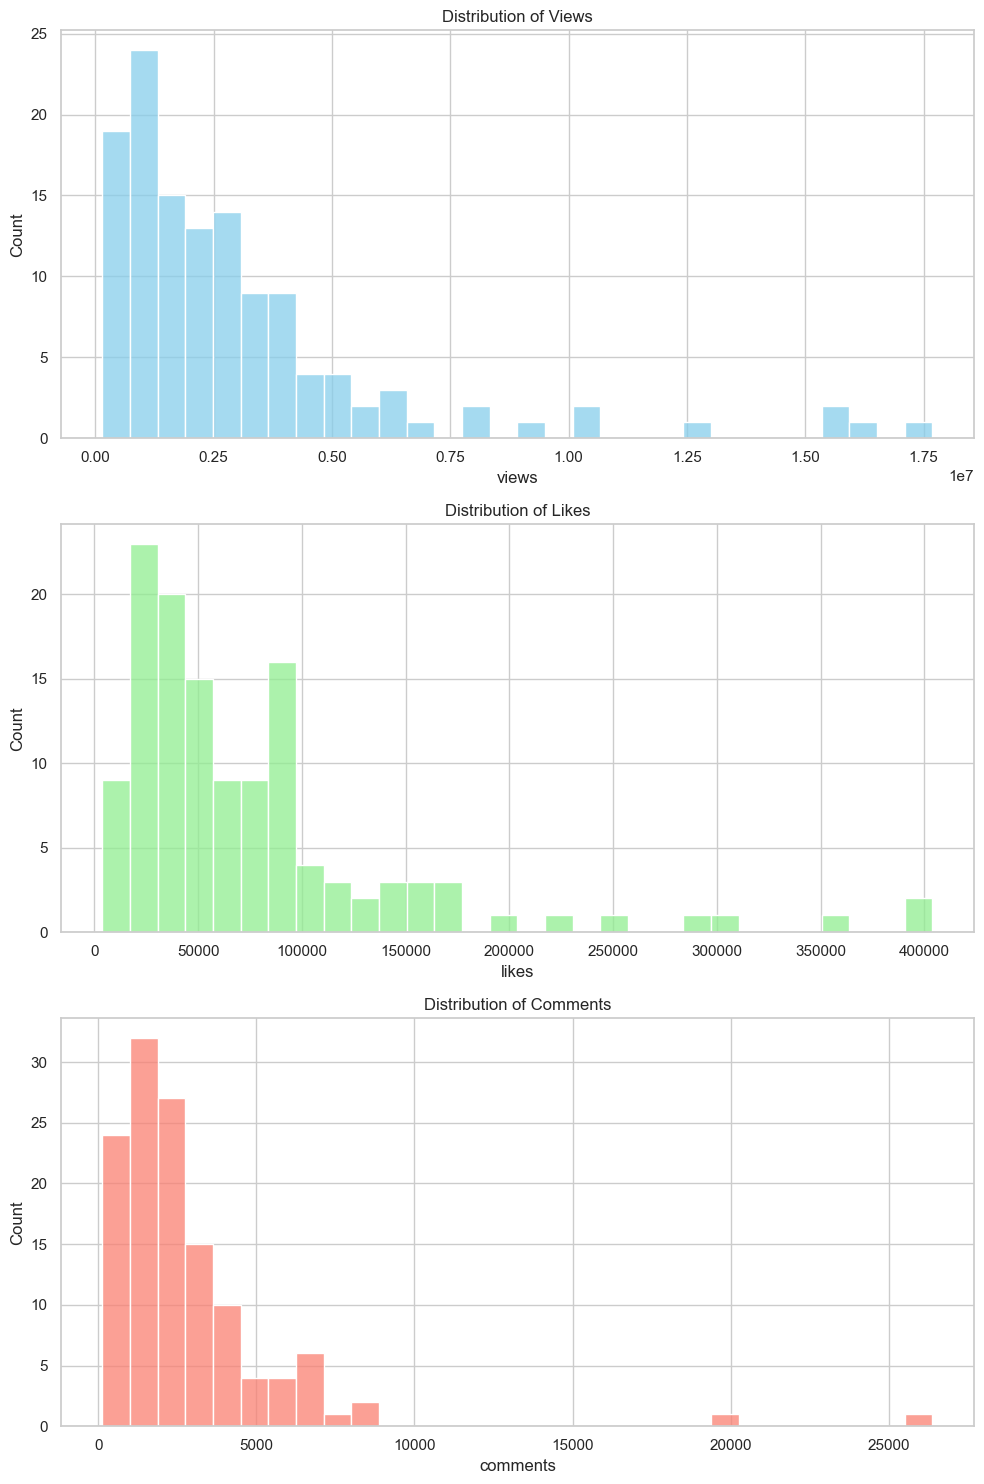

In [89]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
sns.histplot(df_loaded['views'], bins=30, ax=ax[0], color='skyblue')
ax[0].set_title('Distribution of Views')
sns.histplot(df_loaded['likes'], bins=30, ax=ax[1], color='lightgreen')
ax[1].set_title('Distribution of Likes')
sns.histplot(df_loaded['comments'], bins=30, ax=ax[2], color='salmon')
ax[2].set_title('Distribution of Comments')
plt.tight_layout()
plt.show()

# Exploring correlation
<span style="font-size:larger;">We generate a scatter plot to explore the relationship between views and likes for the videos in our dataset. This visualization helps us understand if there is a correlation or pattern between the two variables.</span>

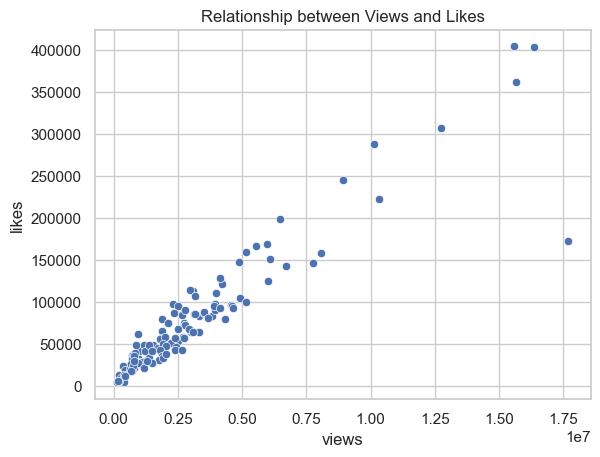

In [90]:
sns.scatterplot(data=df_loaded, x='views', y='likes')
plt.title('Relationship between Views and Likes')
plt.show()

<span style="font-size:larger;">From the scatter plot, the data appears to be fairly correlated, suggesting that videos with higher views tend to have more likes. This observation indicates a positive relationship between the number of views and likes received by the videos. This makes sense intuitively, as videos with higher likes are likely to attract more views and vice-versa. </span>

# Generating a correlation matrix for further analysis
<span style="font-size:larger;">To delve deeper into our analysis, we explore additional correlations between views, likes, and comments in our dataset. By examining these correlations, we aim to gain deeper insights into the relationships between these variables and uncover potential patterns or dependencies.</span>

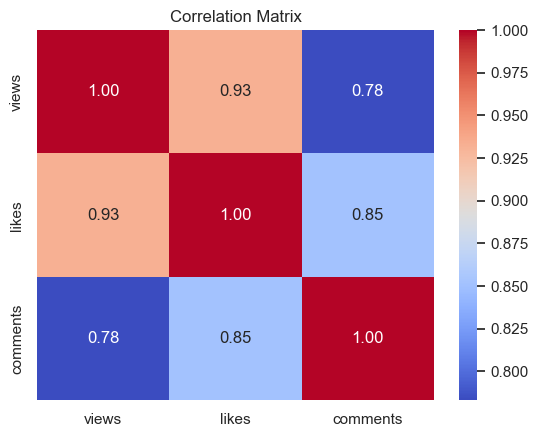

In [91]:
# Compute the correlation matrix
corr = df_loaded[['views', 'likes', 'comments']].corr()

# Generate a heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

<span style="font-size:larger;">We find that views and comments are fairly correlated in our dataset. This observation suggests that videos with higher views tend to attract more comments, indicating a level of engagement with the content.</span>

# Creating a combined metric (popularity_score)
<span style="font-size:larger;">In this segment, we're quantifying the popularity of our videos by creating a composite score based on views, likes, and comments. First, we normalize these metrics to ensure they're on the same scale. Then, we assign weights to each metric to reflect their relative importance in determining popularity.
Using these normalized values and weights, we calculate a popularity score for each video.</span>

<span style="font-size:larger;">The weights were estimated based on trial and error to reflect the real life situation of engagement metrics and popularity. We round the scores to two decimal places for clarity. This score represents the overall popularity of the video, with higher scores indicating greater popularity.</span>
    
<span style="font-size:larger;">After calculating the popularity scores, we sort the videos in our dataset based on these scores, from highest to lowest. This allows us to identify the most popular videos in our collection, providing insights into the content that resonates most with our audience.</span>

In [92]:
# Normalize values to a scale between 0 and 1
max_views = df_loaded['views'].max()
max_likes = df_loaded['likes'].max()
max_comments = df_loaded['comments'].max()

df_loaded['norm_views'] = df_loaded['views'] / max_views
df_loaded['norm_likes'] = df_loaded['likes'] / max_likes
df_loaded['norm_comments'] = df_loaded['comments'] / max_comments

# Define weights for each normalized value
weights = {
    'views': 0.47,
    'likes': 0.38,
    'comments': 0.15
}

# Calculate the popularity score
df_loaded['popularity_score'] = (df_loaded['norm_views'] * weights['views'] +
                                 df_loaded['norm_likes'] * weights['likes'] +
                                 df_loaded['norm_comments'] * weights['comments']) * 100

# Drop intermediate columns if necessary
df_loaded.drop(['norm_views', 'norm_likes', 'norm_comments'], axis=1, inplace=True)

# Optionally, round the popularity score to two decimal places
df_loaded['popularity_score'] = df_loaded['popularity_score'].round(2)

# Sort the DataFrame by popularity score in descending order
sorted_df = df_loaded[['title', 'popularity_score']].sort_values(by='popularity_score', ascending=False)

# Print the first x popularity scores with their titles sorted from highest to lowest
x = len(sorted_df)

print(f"The first {x} popularity scores with their titles (sorted from highest to lowest):")
print(sorted_df.head(x))


The first 127 popularity scores with their titles (sorted from highest to lowest):
                                                 title  popularity_score
71             The hardest problem on the hardest test             90.86
80                 But how does bitcoin actually work?             90.62
75   But what is a neural network? | Chapter 1, Dee...             85.56
52     The most unexpected answer to a counting puzzle             66.45
45   But what is a Fourier series?  From heat flow ...             65.60
68   But what is the Fourier Transform?  A visual i...             58.96
19             Solving Wordle using information theory             53.32
93                             The essence of calculus             50.62
51                 Why do colliding blocks compute pi?             38.88
115     Vectors | Chapter 1, Essence of linear algebra             38.22
53   But why is a sphere's surface area four times ...             37.05
37                    Exponential growth 

# Do the videos that starts with "But" perform better?

<span style="font-size:larger;">Now, there are certain kind of videos from this channel that start with "But what is X" or "But how does Y work," where Grant delves into the fundamentals of trending tech concepts. I love those videos. So I was wondering if they perform better in general. Let's give it a shot!
</span>

<span style="font-size:larger;">To begin our exploration, we filter the DataFrame to extract videos with titles starting with "But." This ensures we focus solely on these intriguing videos that we adore.
</span>

<span style="font-size:larger;">Once we've isolated these videos, we inspect their popularity scores to discern if they have higher popularity scores. By comparing their scores to those of other videos, we'll gain insights into whether these educational gems are indeed more popular overall.
</span>


In [93]:
# Filter the DataFrame for titles starting with "but"
but_titles_df = df_loaded[df_loaded['title'].str.startswith('But')]

# Print the popularity scores of videos starting with "but" in the titles
print("Popularity scores of videos starting with 'but' in the titles:")
print(but_titles_df[['title', 'popularity_score']])


Popularity scores of videos starting with 'but' in the titles:
                                                title  popularity_score
1   But what is a GPT?  Visual intro to transforme...             16.54
3   But why would light "slow down"? | Optics puzz...              8.04
12             But what is the Central Limit Theorem?             15.94
13                         But what is a convolution?             16.97
29  But what are Hamming codes? The origin of erro...             15.50
45  But what is a Fourier series?  From heat flow ...             65.60
47  But what is a partial differential equation?  ...             14.38
53  But why is a sphere's surface area four times ...             37.05
68  But what is the Fourier Transform?  A visual i...             58.96
75  But what is a neural network? | Chapter 1, Dee...             85.56
80                But how does bitcoin actually work?             90.62
97  But what is the Riemann zeta function? Visuali...             23.35


# Let's visualize!

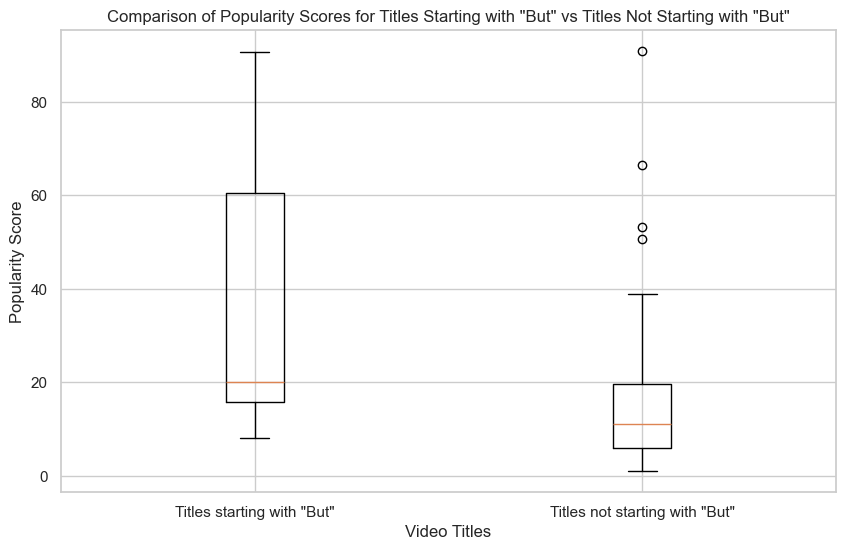

In [94]:
# Split the DataFrame into two groups: titles starting with "but" and titles not starting with "but"
but_titles_df = df_loaded[df_loaded['title'].str.startswith('But')]
non_but_titles_df = df_loaded[~df_loaded['title'].str.startswith('But')]

# Create a box plot or violin plot to compare the distributions of popularity scores
plt.figure(figsize=(10, 6))
plt.boxplot([but_titles_df['popularity_score'], non_but_titles_df['popularity_score']], labels=['Titles starting with "But"', 'Titles not starting with "But"'])
plt.title('Comparison of Popularity Scores for Titles Starting with "But" vs Titles Not Starting with "But"')
plt.ylabel('Popularity Score')
plt.xlabel('Video Titles')
plt.grid(True)
plt.show()

<span style="font-size:larger;">Upon closer inspection, we discover that the videos starting with "But" indeed perform better overall, boasting higher popularity scores compared to other videos in the dataset. That is really good :D 
</span>


# Exploring Topics in 3Blue1Brown video transcripts using NLP

<span style="font-size:larger;">This code segment delves into the transcripts of videos from the 3Blue1Brown YouTube channel, aiming to uncover the underlying topics and themes discussed. It begins by <strong><em>tokenizing</em></strong> and <strong><em>preprocessing</em></strong> the text using <strong><em>spaCy</em></strong>, a natural language processing library. This step ensures that the text is prepared for analysis by removing common stop words and punctuation, allowing the focus to be on the most meaningful content.</span>

<span style="font-size:larger;">Following preprocessing, the text undergoes <strong><em>vectorization</em></strong> using the <strong><em>CountVectorizer</em></strong> from <strong><em>scikit-learn</em></strong>. This process converts the text into a numerical format, making it suitable for <strong><em>topic modeling</em></strong>. The vectorized text is then fed into <strong><em>Latent Dirichlet Allocation (LDA)</em></strong>, a powerful algorithm for discovering latent topics within a collection of documents. LDA assigns each word in the text to a topic based on statistical inference.</span>

<span style="font-size:larger;">With <strong><em>topic modeling</em></strong> applied, the code extracts the top words associated with each identified topic and generates a descriptive name for each topic. This naming step provides a concise summary of the main themes represented by the words most strongly associated with each topic. These topics offer valuable insights into the subjects covered in the videos, enabling a deeper understanding of the content and its overarching themes.</span>

<span style="font-size:larger;">The process of <strong><em>preprocessing</em></strong>, <strong><em>vectorization</em></strong>, and <strong><em>topic modeling</em></strong> is repeated for each transcript in the DataFrame, ensuring comprehensive coverage of all videos in the dataset. Once topics are extracted for each transcript, they are added to the DataFrame, enriching the dataset with information about the main themes discussed in the videos. Finally, the updated DataFrame with topics is saved to a CSV file for further analysis, providing a valuable resource for exploring the content of the 3Blue1Brown YouTube channel in greater depth.</span>

In [95]:
# Import necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import spacy

# Load English language model
nlp = spacy.load("en_core_web_sm")

# Tokenization
def tokenize(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

# Define function to preprocess and vectorize text
def preprocess_and_vectorize(text):
    # Tokenize and lemmatize the text
    tokenized_text = tokenize(text)
    processed_text = ' '.join(tokenized_text)

    # Vectorization
    vectorizer = CountVectorizer(max_features=1000, 
                                 stop_words='english', 
                                 lowercase=True, 
                                 token_pattern='[a-zA-Z]{2,}')

    # Fit and transform the processed text
    X = vectorizer.fit_transform([processed_text])
    return X, vectorizer

# Define function for topic modeling using LDA
def perform_topic_modeling(X, vectorizer, n_topics=5):
    lda_model = LatentDirichletAllocation(n_components=n_topics,
                                          max_iter=10,
                                          learning_method='online',
                                          random_state=42,
                                          batch_size=128,
                                          evaluate_every=-1,
                                          n_jobs=-1)
    lda_output = lda_model.fit_transform(X)
    return lda_output, lda_model

# Define function to generate topic names
def generate_topic_names(lda_model, vectorizer, n_words=10):
    topic_names = {}
    for idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[-n_words:][::-1]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_idx]
        topic_names[idx] = " ".join(top_words).capitalize()
    return topic_names

# Preprocess, vectorize, and perform topic modeling for each transcript
topics_per_transcript = []
for transcript in df_loaded['transcript']:
    # Preprocess and vectorize text
    X, vectorizer = preprocess_and_vectorize(transcript)

    # Perform topic modeling
    lda_output, lda_model = perform_topic_modeling(X, vectorizer)

    # Generate topic names
    topic_names = generate_topic_names(lda_model, vectorizer)

    # Append topics to the list
    topics_per_transcript.append(topic_names)

# Add topics to DataFrame
df_loaded['topics'] = topics_per_transcript

# Save the DataFrame to a CSV file
df_loaded.to_csv('3blue1brown_video_data_complete.csv', index=False)

# Reload the DataFrame to verify changes
df_loaded = pd.read_csv('3blue1brown_video_data_complete.csv')

print(df_loaded)

                                                 title  \
0    Attention in transformers, visually explained ...   
1    But what is a GPT?  Visual intro to transforme...   
2    4 questions about the refractive index | Optic...   
3    But why would light "slow down"? | Optics puzz...   
4     25 Math explainers you may enjoy | SoME3 results   
5    Explaining the barber pole effect from origins...   
6    Polarized light in sugar water | Optics puzzles 1   
7    A pretty reason why Gaussian + Gaussian = Gaus...   
8    This pattern breaks, but for a good reason | M...   
9    How They Fool Ya (live) | Math parody of Halle...   
10   Convolutions | Why X+Y in probability is a bea...   
11   Why π is in the normal distribution (beyond in...   
12              But what is the Central Limit Theorem?   
13                          But what is a convolution?   
14   Researchers thought this was a bug (Borwein in...   
15   What makes a great math explanation? | SoME2 r...   
16            

# Cluster Analysis based on the topics

<span style="font-size:larger;">This code segment utilizes clustering techniques to group videos based on their extracted topics. Here's a breakdown of the process:</span>

<span style="font-size:larger;"><strong><em>1. Data Preparation:</em></strong> The relevant columns, including 'title', 'transcript', and 'topics', are selected from the DataFrame. The 'topics' column is converted into a string format for further processing.</span>

<span style="font-size:larger;"><strong><em>2. Vectorization:</em></strong> The topics are vectorized using the <strong><em>TF-IDF Vectorizer</em></strong> from scikit-learn, which converts text data into numerical vectors.</span>

<span style="font-size:larger;"><strong><em>3. Clustering:</em></strong> <strong><em>K-means clustering</em></strong> is applied to the vectorized topics to group them into clusters. The optimal number of clusters is determined beforehand.</span>

<span style="font-size:larger;"><strong><em>4. Evaluation:</em></strong> The quality of clustering is evaluated using the <strong><em>silhouette score</em></strong>, which measures the compactness and separation of the clusters.</span>

<span style="font-size:larger;"><strong><em>5. Results Analysis:</em></strong> The results are grouped by clusters, and statistics such as the <strong><em>average popularity score</em></strong> and the number of videos in each cluster are computed and displayed.</span>

<span style="font-size:larger;"><strong><em>6. Visualization:</em></strong> A <strong><em>bar plot</em></strong> is generated to visualize the average popularity score for each cluster, providing insights into the distribution of popularity among different topic clusters.</span>

Silhouette Score: 0.04877263254676968
                                                     title popularity_score  \
                                                      list             mean   
cluster                                                                       
0        [Attention in transformers, visually explained...        14.062083   
1        [Group theory, abstraction, and the 196,883-di...        20.273000   
2        [A quick trick for computing eigenvalues | Cha...        12.269231   
3        [Convolutions | Why X+Y in probability is a be...        19.842222   
4        [25 Math explainers you may enjoy | SoME3 resu...        11.172800   
5        [Why this puzzle is impossible, But what is a ...        41.656667   
6        [But what is a GPT?  Visual intro to transform...        22.033529   
7        [This pattern breaks, but for a good reason | ...        25.446000   
8        [4 questions about the refractive index | Opti...         8.940000   

             

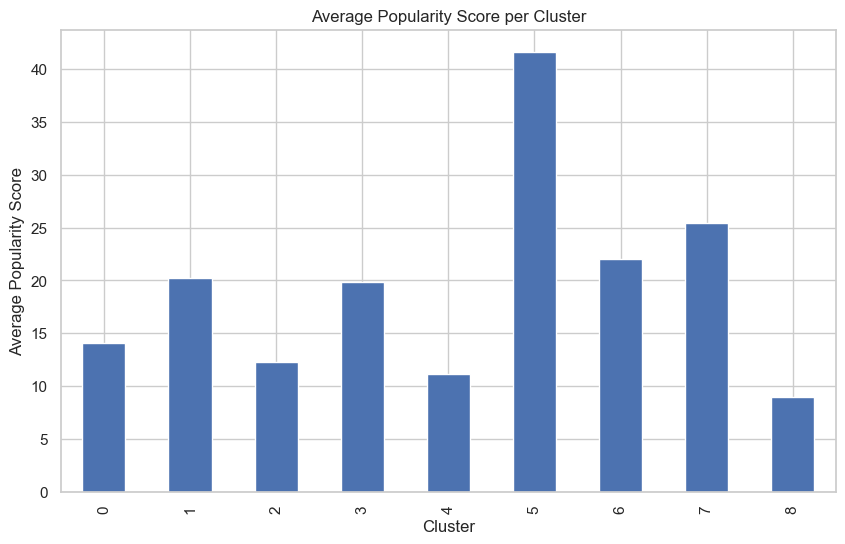

In [96]:
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df_transcripts = df_loaded[['title', 'transcript', 'topics']].copy()
# Ensure that each topic is a single string
df_transcripts['topics'] = df_transcripts['topics'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_transcripts['topics_str'] = df_transcripts['topics'].apply(lambda x: ' '.join([f"{k}: {v}" for k, v in x.items()]))

# Add the popularity_score column from df_loaded to df_transcripts
df_transcripts['popularity_score'] = df_loaded['popularity_score']

# Step 2: Vectorize the Topics
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_transcripts['topics_str'])

# Step 4: Perform Clustering with Optimal Number of Clusters 
optimal_clusters = 9
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_transcripts['cluster'] = kmeans.fit_predict(X)

# Step 5: Evaluate the Clustering with Silhouette Score
score = silhouette_score(X, kmeans.labels_)
print(f'Silhouette Score: {score}')

# Step 6: Group by Clusters and Display the Results
grouped = df_transcripts.groupby('cluster').agg({
    'title': list,
    'popularity_score': ['mean', 'count']
})

print(grouped)

# Plot the average popularity score for each cluster
plt.figure(figsize=(10, 6))
grouped['popularity_score']['mean'].plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Average Popularity Score')
plt.title('Average Popularity Score per Cluster')
plt.show()

<span style="font-size:larger;">For this clustering analysis, we selected the number of clusters based on the <strong><em>highest silhouette score</em></strong>, which resulted in <strong><em>9 clusters</em></strong>. This choice allows for optimal grouping of the videos according to their extracted topics, maximizing the cohesion within each cluster while maintaining separation between clusters.</span>

<span style="font-size:larger;">Next, we'll examine the clusters to understand how videos are grouped based on topics, revealing patterns and themes within the collection.</span>

In [97]:
# Group the videos by their clusters and display the details for each cluster
clusters = df_transcripts['cluster'].unique()
for cluster in sorted(clusters):
    print(f"Cluster {cluster}:\n")
    cluster_videos = df_transcripts[df_transcripts['cluster'] == cluster]
    for index, row in cluster_videos.iterrows():
        print(f"Title: {row['title']}")
        print()  # Print an empty line for separation
    print("-" * 50)  # Separator for clusters


Cluster 0:

Title: Attention in transformers, visually explained | Chapter 6, Deep Learning

Title: But what is the Central Limit Theorem?

Title: But what is a convolution?

Title: Researchers thought this was a bug (Borwein integrals)

Title: Beyond the Mandelbrot set, an intro to holomorphic dynamics

Title: How (and why) to raise e to the power of a matrix | DE6

Title: Why “probability of 0” does not mean “impossible” | Probabilities of probabilities, part 2

Title: Solving the heat equation | DE3

Title: But what is a partial differential equation?  | DE2

Title: Differential equations, a tourist's guide | DE1

Title: The other way to visualize derivatives | Chapter 12, Essence of calculus

Title: Winding numbers and domain coloring

Title: The more general uncertainty principle, regarding Fourier transforms

Title: Backpropagation calculus | Chapter 4, Deep learning

Title: What is backpropagation really doing? | Chapter 3, Deep learning

Title: Gradient descent, how neural netw

# Extracting the video length, comments and duration
<span style="font-size:larger;">To facilitate further analysis, additional data is extracted from the channel. This includes details such as publication dates, video durations, and comments for each video. By incorporating this supplementary information into the dataset, we aim to provide a more comprehensive basis for in-depth analysis and exploration of the channel's content.</span>

In [98]:
from googleapiclient.discovery import build
import isodate

# Initialize the YouTube API client with your API key
api_key = key
youtube = build('youtube', 'v3', developerKey=api_key)

# Function to fetch video details including publication date and duration
def fetch_video_details(video_id):
    try:
        response = youtube.videos().list(
            part='snippet,contentDetails',  # Fetch snippet for publication date and contentDetails for duration
            id=video_id
        ).execute()

        if response['items']:
            snippet = response['items'][0].get('snippet', {})
            content_details = response['items'][0].get('contentDetails', {})
            published_at = snippet.get('publishedAt', '1970-01-01T00:00:00Z')
            duration = content_details.get('duration', 'PT0S')
            return published_at, duration
        else:
            return '1970-01-01T00:00:00Z', 'PT0S'
    except Exception as e:
        return '1970-01-01T00:00:00Z', 'PT0S'

# Function to fetch comments for a video
def get_video_comments(video_id, max_results=100):
    comments = []
    try:
        results = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=max_results,
            textFormat='plainText'
        ).execute()
        
        while results:
            for item in results['items']:
                comment = item['snippet']['topLevelComment']['snippet']['textOriginal']
                comments.append(comment)
            if 'nextPageToken' in results:
                results = youtube.commentThreads().list(
                    part='snippet',
                    videoId=video_id,
                    pageToken=results['nextPageToken'],
                    maxResults=max_results,
                    textFormat='plainText'
                ).execute()
            else:
                break
    except Exception as e:
        print(f"Error fetching comments for video {video_id}: {e}")
    
    return comments


# Fetch video details for each video
df_videos['publication_date'], df_videos['duration'] = zip(*df_videos['video_id'].apply(fetch_video_details))
df_videos['comments'] = df_videos['video_id'].apply(get_video_comments)

# Convert publication_date to datetime
df_videos['publication_date'] = pd.to_datetime(df_videos['publication_date'])

# Extract the year from the publication date
df_videos['year'] = df_videos['publication_date'].dt.year

# Convert duration from ISO 8601 format to seconds
df_videos['duration_seconds'] = df_videos['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

# Merge the new information with df_loaded
df_loaded = pd.merge(df_loaded, df_videos[['video_id', 'publication_date', 'year', 'duration_seconds', 'comments']], on='video_id', how='left')

# Save the DataFrame to a CSV file
df_loaded.to_csv('3blue1brown_video_data_complete.csv', index=False)

# Reload the DataFrame to verify changes
df_loaded = pd.read_csv('3blue1brown_video_data_complete.csv')

# Display the full dataset
print(df_loaded)

                                                 title  \
0    Attention in transformers, visually explained ...   
1    But what is a GPT?  Visual intro to transforme...   
2    4 questions about the refractive index | Optic...   
3    But why would light "slow down"? | Optics puzz...   
4     25 Math explainers you may enjoy | SoME3 results   
5    Explaining the barber pole effect from origins...   
6    Polarized light in sugar water | Optics puzzles 1   
7    A pretty reason why Gaussian + Gaussian = Gaus...   
8    This pattern breaks, but for a good reason | M...   
9    How They Fool Ya (live) | Math parody of Halle...   
10   Convolutions | Why X+Y in probability is a bea...   
11   Why π is in the normal distribution (beyond in...   
12              But what is the Central Limit Theorem?   
13                          But what is a convolution?   
14   Researchers thought this was a bug (Borwein in...   
15   What makes a great math explanation? | SoME2 r...   
16            

# Temporal Analysis
<span style="font-size:larger;">We've plotted the average popularity score, views, and likes of the videos over the years. These visualizations provide a glimpse into the channel's performance trends over time. The first graph shows the average popularity score, indicating the overall reception of the videos. The second and third graphs depict the average views and likes per video, respectively, offering insights into viewer engagement and appreciation. By observing these trends, we can discern how the channel's content has resonated with its audience over different periods.</span>

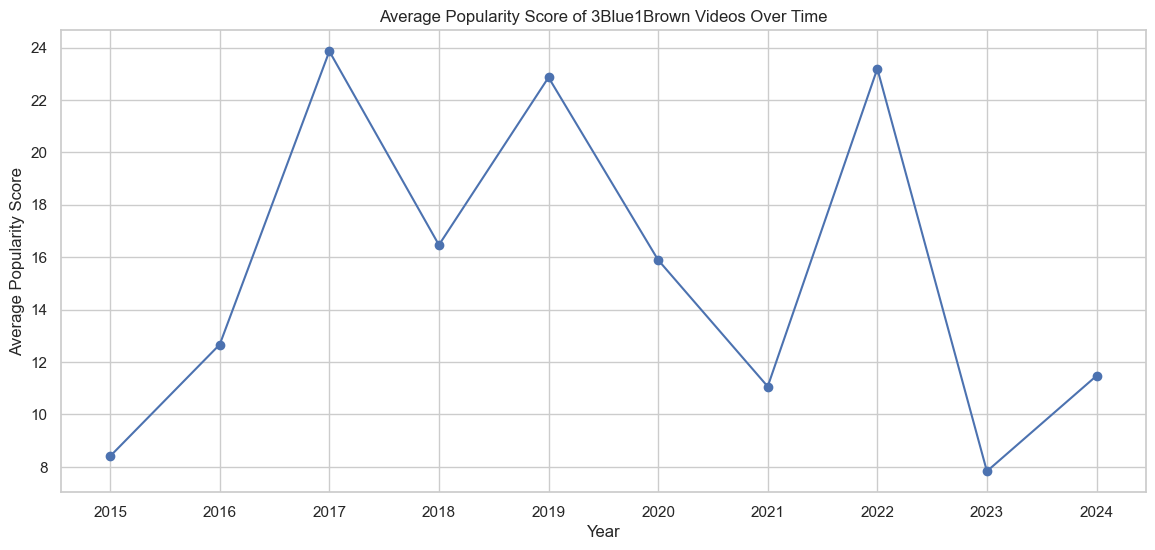

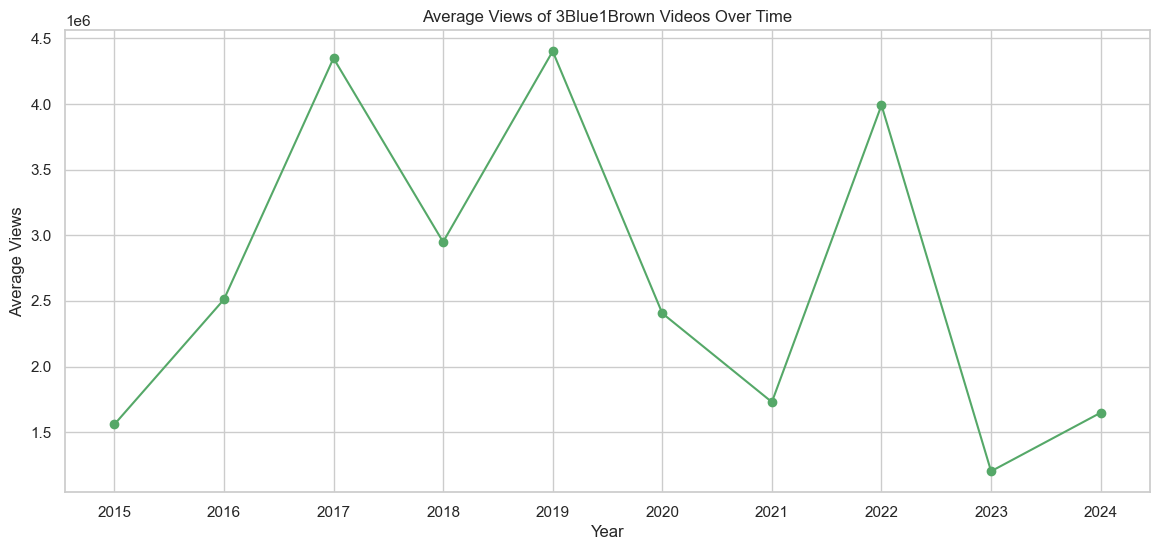

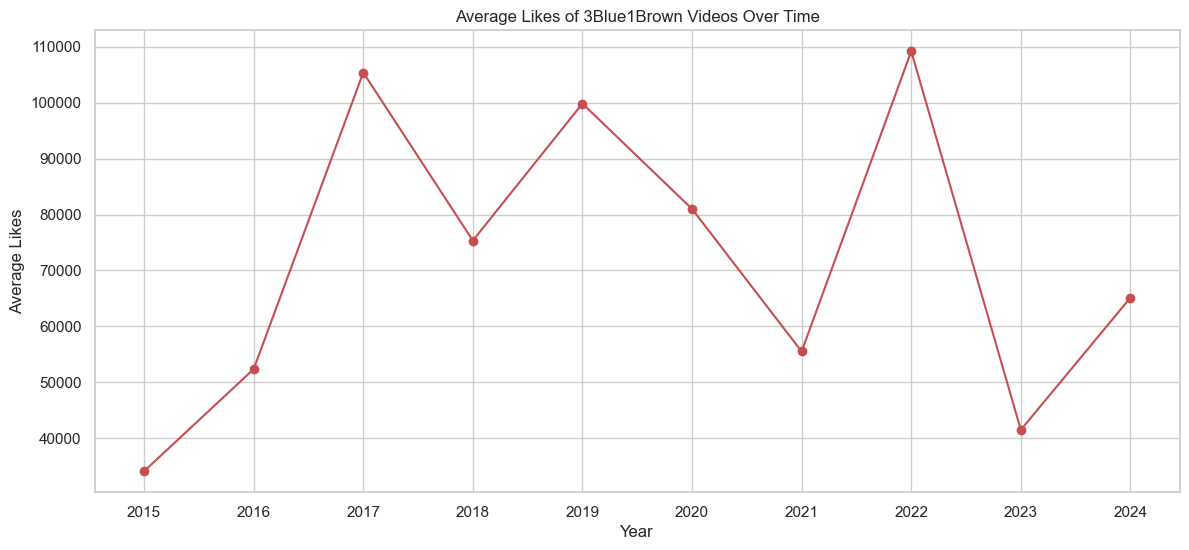

In [99]:
# First, let's rename the existing columns in df_loaded to avoid conflicts during the merge
df_loaded.rename(columns={'publication_date': 'publication_date_old', 'year': 'year_old', 'duration_seconds': 'duration_seconds_old'}, inplace=True)

# Ensure the DataFrame has the required columns from df_videos
df_loaded = pd.merge(df_loaded, df_videos[['video_id', 'publication_date', 'year', 'duration_seconds']], on='video_id', how='left')

# Drop the old publication_date and year columns
df_loaded.drop(columns=['publication_date_old', 'year_old', 'duration_seconds_old'], inplace=True)

# Group by year and calculate the average popularity score, views, and likes
yearly_metrics = df_loaded.groupby('year').agg({
    'popularity_score': 'mean',
    'views': 'mean',
    'likes': 'mean'
}).reset_index()

# Plot the trend of average popularity score over the years
plt.figure(figsize=(14, 6))
plt.plot(yearly_metrics['year'], yearly_metrics['popularity_score'], marker='o', linestyle='-', color='b')
plt.title('Average Popularity Score of 3Blue1Brown Videos Over Time')
plt.xlabel('Year')
plt.ylabel('Average Popularity Score')
plt.grid(True)
plt.xticks(yearly_metrics['year'])  # Ensure all years are shown on the x-axis
plt.show()

# Plot the trend of average views over the years
plt.figure(figsize=(14, 6))
plt.plot(yearly_metrics['year'], yearly_metrics['views'], marker='o', linestyle='-', color='g')
plt.title('Average Views of 3Blue1Brown Videos Over Time')
plt.xlabel('Year')
plt.ylabel('Average Views')
plt.grid(True)
plt.xticks(yearly_metrics['year'])  # Ensure all years are shown on the x-axis
plt.show()

# Plot the trend of average likes over the years
plt.figure(figsize=(14, 6))
plt.plot(yearly_metrics['year'], yearly_metrics['likes'], marker='o', linestyle='-', color='r')
plt.title('Average Likes of 3Blue1Brown Videos Over Time')
plt.xlabel('Year')
plt.ylabel('Average Likes')
plt.grid(True)
plt.xticks(yearly_metrics['year'])  # Ensure all years are shown on the x-axis
plt.show()

df_loaded.drop(columns=['publication_date_x', 'year_x', 'duration_seconds_x', 'publication_date_y', 'year_y', 'duration_seconds_y'], errors='ignore', inplace=True)

# Save the DataFrame to a CSV file
df_loaded.to_csv('3blue1brown_video_data_complete.csv', index=False)

# Reload the DataFrame to verify changes
df_loaded = pd.read_csv('3blue1brown_video_data_complete.csv')

<span style="font-size:larger;">Looks like 2017, 2019, and 2022 stood out as particularly successful periods for the channel. During these years, there appears to have been a significant uptick in the average popularity score, views, and likes, suggesting a heightened level of engagement and appreciation from the audience. These periods coincide with the release of notable or impactful content that garnered widespread attention and positive feedback.</span>

# Analyzing the correlation between video duration and popularity score
<span style="font-size:larger;">This code segment analyzes the correlation between the duration of videos and their popularity scores.</span>

<span style="font-size:larger;"><strong><em>Step 1:</em></strong> Using the <strong><em>Pearson correlation coefficient</em></strong>, the code computes the correlation between the duration of each video and its popularity score. This statistical measure quantifies the strength and direction of the linear relationship between the two variables.</span>

<span style="font-size:larger;"><strong><em>Step 2:</em></strong> A scatter plot is generated to visually represent the relationship. Each point on the plot corresponds to a video, with its x-coordinate indicating the duration and its y-coordinate representing the popularity score. Transparency (alpha) and edge colors are adjusted for clarity, and gridlines are included for better visualization.</span>

<span style="font-size:larger;">The scatter plot facilitates the examination of any discernible patterns or trends between video duration and popularity score, while the correlation coefficient offers a numerical insight into the strength and direction of this relationship.</span>

Correlation between video length and popularity score: 0.1952112835294517


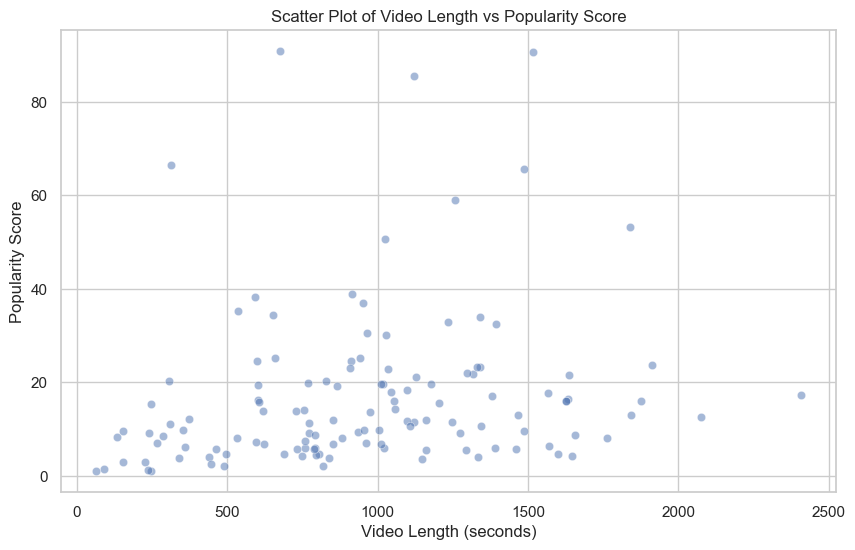

In [100]:
# Load the data
df = pd.read_csv('3blue1brown_video_data_complete.csv')

# Step 1: Extract the duration of each video
# The duration of each video is already in the column 'duration_seconds'

# Step 2: Calculate the correlation between video length and popularity score
correlation = df['duration_seconds'].corr(df['popularity_score'])
print(f'Correlation between video length and popularity score: {correlation}')

# Step 3: Visualize the relationship using scatter plots
plt.figure(figsize=(10, 6))
plt.scatter(df['duration_seconds'], df['popularity_score'], alpha=0.5, edgecolors='w', linewidth=0.5)
plt.title('Scatter Plot of Video Length vs Popularity Score')
plt.xlabel('Video Length (seconds)')
plt.ylabel('Popularity Score')
plt.grid(True)
plt.show()

<span style="font-size:larger;">The correlation between video length and popularity score is approximately 0.20, suggesting a weak positive correlation.</span>

# Sentiment Analysis of Video Comments with VADER
<span style="font-size:larger;">In this code segment, our goal is to analyze the sentiment expressed in the comments associated with each video from the channel. We aim to understand the overall sentiment of the audience towards the content of these videos.</span>

<span style="font-size:larger;"><strong><em>Text Preprocessing:</em></strong> Before conducting sentiment analysis, we preprocess the comments to ensure consistency and remove any irrelevant information. This involves removing URLs, special characters, and numbers, as well as converting the text to lowercase.</span>

<span style="font-size:larger;"><strong><em>Sentiment Analysis:</em></strong> We utilize the <strong><em>VADER</em></strong> (<strong><em>Valence Aware Dictionary and sEntiment Reasoner</em></strong>) lexicon for sentiment analysis. <strong><em>VADER</em></strong> is specifically designed for analyzing sentiment in social media texts. It provides a polarity score for each comment, indicating its sentiment intensity.</span>

<span style="font-size:larger;"><strong><em>Scoring and Aggregation:</em></strong> After obtaining sentiment scores for each comment, we aggregate these scores to calculate the average sentiment score for each video. This allows us to quantify the overall sentiment expressed in the comments associated with each video.</span>

<span style="font-size:larger;"><strong><em>Data Management:</em></strong> Finally, we clean up the dataset by removing certain columns containing intermediate results and unnecessary information. This ensures that the dataset remains concise and relevant for further analysis.</span>

In [101]:
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Preprocess comments
def preprocess_comments(comments):
    cleaned_comments = []
    for comment in comments.split(","):
        # Remove URLs
        comment = re.sub(r'http\S+', '', comment)
        # Remove special characters and numbers
        comment = re.sub(r'[^A-Za-z\s]+', '', comment)
        # Convert to lowercase
        comment = comment.lower()
        cleaned_comments.append(comment)
    return cleaned_comments

# Perform sentiment analysis and get sentiment scores
def analyze_sentiments(comments):
    sentiment_scores = [sia.polarity_scores(comment)['compound'] for comment in comments]
    return sentiment_scores

# Apply preprocessing and sentiment analysis to comments in df_loaded
df_loaded['cleaned_comments'] = df_loaded['comments_y'].apply(preprocess_comments)
df_loaded['sentiment_scores'] = df_loaded['cleaned_comments'].apply(analyze_sentiments)

# Calculate average sentiment score for each video
df_loaded['avg_sentiment_score'] = df_loaded['sentiment_scores'].apply(lambda scores: sum(scores) / len(scores) if scores else 0)

# Delete specified columns with errors='ignore'
df_loaded.drop(columns=['positive_comments', 'negative_comments', 'neutral_comments', 'sentiment_classifications','sentiment_analysis', 'sentiment_scores', 'cleaned_comments'], errors='ignore', inplace=True)
# Save the updated DataFrame to a CSV file
df_loaded.to_csv('3blue1brown_video_data_complete.csv', index=False)

# Reload the DataFrame to verify changes
df_loaded = pd.read_csv('3blue1brown_video_data_complete.csv')

# Display the full dataset
#print(df_loaded)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ahnaftajwarrafid/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Top 10 Videos by Popularity Score

In [102]:
df_loaded = pd.read_csv('3blue1brown_video_data_complete.csv')

# Sort the DataFrame by popularity_score in descending order
top_videos = df_loaded.sort_values(by='popularity_score', ascending=False).head(10)

# Display the top 10 videos with all columns
print(top_videos)

                                                 title  \
71             The hardest problem on the hardest test   
80                 But how does bitcoin actually work?   
75   But what is a neural network? | Chapter 1, Dee...   
52     The most unexpected answer to a counting puzzle   
45   But what is a Fourier series?  From heat flow ...   
68   But what is the Fourier Transform?  A visual i...   
19             Solving Wordle using information theory   
93                             The essence of calculus   
51                 Why do colliding blocks compute pi?   
115     Vectors | Chapter 1, Essence of linear algebra   

                                             url     video_id  \
71   https://www.youtube.com/watch?v=OkmNXy7er84  OkmNXy7er84   
80   https://www.youtube.com/watch?v=bBC-nXj3Ng4  bBC-nXj3Ng4   
75   https://www.youtube.com/watch?v=aircAruvnKk  aircAruvnKk   
52   https://www.youtube.com/watch?v=HEfHFsfGXjs  HEfHFsfGXjs   
45   https://www.youtube.com/watch?v

# Analyzing Relationship between Sentiment and Popularity Score
<span style="font-size:larger;">This code segment creates a scatter plot to visualize the relationship between the average sentiment score and the popularity score of videos in the dataset. After plotting the data, the code calculates the Pearson correlation coefficient and its associated p-value using the <strong><em>pearsonr</em></strong> function from the SciPy library. The <strong><em>correlation coefficient</em></strong> measures the strength and direction of the linear relationship between the two variables, ranging from -1 to 1. A positive coefficient indicates a positive relationship, while a negative coefficient indicates a negative relationship. The <strong><em>p-value</em></strong> indicates the significance of the correlation.</span>

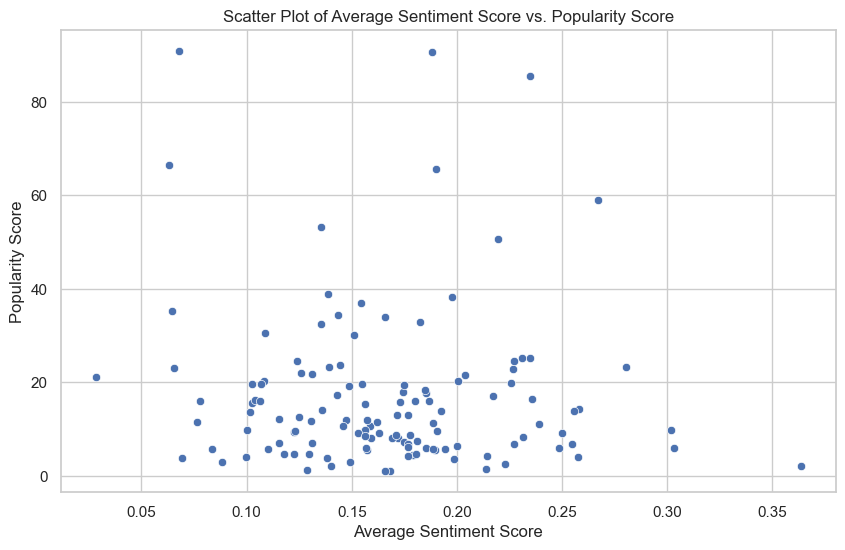

Correlation coefficient: -0.06
P-value: 4.73e-01


In [103]:
from scipy.stats import pearsonr

# Load the DataFrame from the CSV file
df_loaded = pd.read_csv('3blue1brown_video_data_complete.csv')

# Scatter plot of average sentiment score vs. popularity score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_sentiment_score', y='popularity_score', data=df_loaded)
plt.title('Scatter Plot of Average Sentiment Score vs. Popularity Score')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Popularity Score')
plt.grid(True)
plt.show()

# Calculate the correlation coefficient
correlation, p_value = pearsonr(df_loaded['avg_sentiment_score'], df_loaded['popularity_score'])
print(f'Correlation coefficient: {correlation:.2f}')
print(f'P-value: {p_value:.2e}')

<span style="font-size:larger;">The correlation coefficient of -0.06 suggests a very weak negative correlation between the average sentiment score and the popularity score of the videos. With a p-value of 4.95e-01, this correlation is not statistically significant so it could be by chance.</span>

# Analyzing Topic Words 
<span style="font-size:larger;">This code segment generates WordClouds to visualize the most common topic words discussed in the top 10 most popular videos and all videos. Word frequency is calculated for both sets of videos, and WordClouds are generated to visually represent the most common words. Finally, the code identifies significant words that are more frequent in the top videos compared to all videos, providing insights into audience preferences.</span>

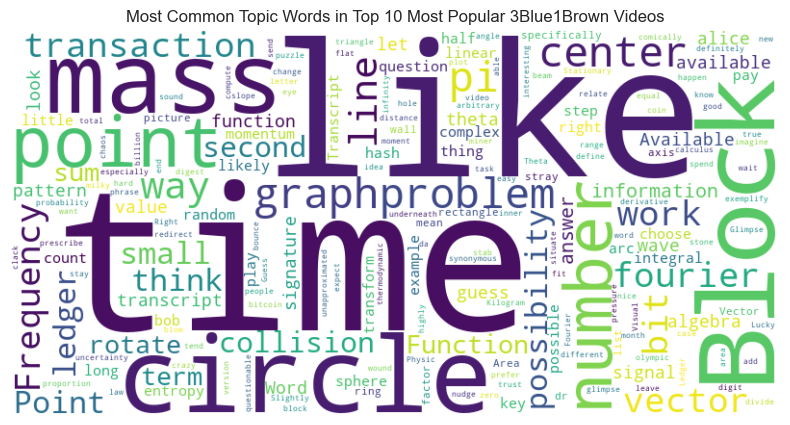

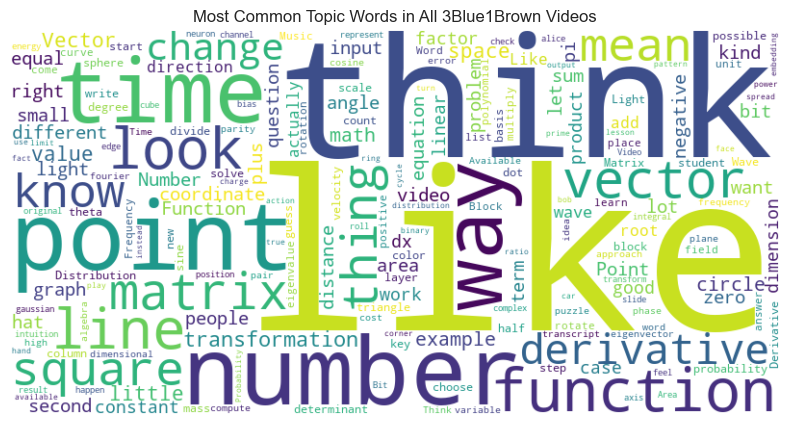

In [104]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import ast

# Convert strings in 'topics' column to dictionaries
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return val

df_loaded['topics'] = df_loaded['topics'].apply(safe_literal_eval)

# Extract top 10 most popular videos
top_videos = df_loaded.nlargest(10, 'popularity_score')

# Extract all topic words from the topics column for top videos
top_topic_words = []

for topic_dict in top_videos['topics']:
    if isinstance(topic_dict, dict):
        for words in topic_dict.values():
            top_topic_words.extend(words.split())

# Count the frequency of topic words in top videos
top_word_counter = Counter(top_topic_words)

# Extract all topic words from the topics column for all videos
all_topic_words = []

for topic_dict in df_loaded['topics']:
    if isinstance(topic_dict, dict):
        for words in topic_dict.values():
            all_topic_words.extend(words.split())

# Count the frequency of topic words in all videos
all_word_counter = Counter(all_topic_words)

# Generate WordCloud for top videos
top_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_word_counter)

plt.figure(figsize=(10, 5))
plt.imshow(top_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Topic Words in Top 10 Most Popular 3Blue1Brown Videos')
plt.show()

# Generate WordCloud for all videos
all_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(all_word_counter)

plt.figure(figsize=(10, 5))
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Topic Words in All 3Blue1Brown Videos')
plt.show()

# Find words that are more frequent in top videos
significant_words = {word: top_word_counter[word] for word in top_word_counter 
                     if top_word_counter[word] > all_word_counter[word]}